# PA005: High Value Customer Indentification ( Insiders )

In [96]:
import re
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns

import umap.umap_ as umap

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import mixture as mx
from sklearn import manifold as mn 
from sklearn import ensemble as en
from sklearn import decomposition as dd
from sklearn import preprocessing as pp

from plotly import express as px

from matplotlib import pyplot as plt

from sqlalchemy import create_engine
from scipy.cluster import hierarchy as hc

### 0.2. Load Dataset

In [2]:
# load data
df_raw = pd.read_csv('/Users/thiago/Thiago/Data_Science/comunidade_ds/insiders_clustering/data/raw/ecommerce.csv', encoding='unicode_escape' )

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

## <font color='red'> 1.0. Descrição dos Dados </font>

In [3]:
df1 = df_raw.copy()

### 1.1. Rename Columns

In [4]:
cols_new = [ 'invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country' ]
df1.columns = cols_new

### 1.2. Data Dimensions

In [5]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


### 1.3. Data Types

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4. Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5. Replace NA

In [8]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [9]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

df1.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [10]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### 1.6. Change Types

In [11]:
# invoice_date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.7. Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 1.7.1. Numerical Attributes

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m1


,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.2. Categorical Attributes

In [15]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


<b>Invoice No</b>

In [16]:
# problema: Temos o invoice com letras e numeros
#df1['invoice_no'].astype( int )

# Identificação
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool ( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number os invoices: {}'.format( len ( df_letter_invoices ) ) ) 
print( 'Total number os negative quantity: {}'.format( len( df_letter_invoices[df_letter_invoices['quantity'] < 0 ] ) ) )

Total number os invoices: 9291
Total number os negative quantity: 9288


In [17]:
#cat_attributes['invoice_no'].astype( int )
len( cat_attributes.loc[ cat_attributes['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'invoice_no'].drop_duplicates() )
#cat_attributes.loc[173995, : ]

3839

<b>Stock Code</b>

In [18]:
# stock code
#at_least_one_string = cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x: bool ( re.search( '[^0-9+]', x ) ) ), 'stock_code'].head()

#print( at_least_one_string )

#
#cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique() 
df1.loc[cat_attributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001


In [19]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool ( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Ação:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

## <font color='red'> 2.0. Filtragem das Variáveis </font>

In [24]:
df2 = df1.copy()

In [25]:
# ===== Numerical Attributes ======
# unit price > 0.04
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# ===== Categorical Attributes ======
# stock code != [ POST, D, M, DOT, CRUK ]
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK']) ] 

# description
df2 = df2.drop( columns='description', axis=1 )

# map
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] ) ] 

## quantity - Negative numbers means product returns
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

## <font color='red'> 3.0. Feature Engineering </font>

In [50]:
df3 = df2.copy()

### 3.1. Feature Creation

In [51]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code','quantity', 'invoice_date', 'unit_price', 'country' ], axis=1 ).drop_duplicates( ignore_index=True)

In [52]:
df_ref.shape

(5786, 1)

In [53]:
df_ref.isna().sum()

customer_id    0
dtype: int64

#### 3.1.1. Gross Revenue

In [54]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, how='left', on='customer_id' )
df_ref.isna().sum()

/var/folders/w5/0w2xv4r95g1gfgbzpp2dm6gr0000gn/T/ipykernel_34295/225208262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

#### 3.1.2. Recency - Day from last Purchase

In [55]:
# Recency - It depends on product returns
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2_purchase['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, how='left', on='customer_id' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

#### 3.1.3. Quantity of Products Purchased

In [56]:
# Número de Produtos - It depends os product returns
df_frequency = (df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' )
                                                                .count()
                                                                .reset_index()
                                                                .rename( columns={'stock_code':'qtde_products'} ))
df_ref = pd.merge( df_ref, df_frequency, how='left', on='customer_id' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
dtype: int64

#### 3.1.4. Frequency Purchase

In [57]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                    .groupby( 'customer_id' )
                                                    .agg( max_ = ( 'invoice_date', 'max' ),
                                                          min_ = ( 'invoice_date', 'min' ),
                                                         days_ = ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                          buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[[ 'buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

In [58]:
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
dtype: int64

#### 3.1.5. Number os Returns

In [59]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

## <font color='red'> 4.0. EDA ( Exploratory Data Analysis )</font>

In [65]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_products    0
frequency        0
qtde_returns     0
dtype: int64

### 4.1. Estudo do Espaço

In [66]:
# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[ cols_selected ].drop( columns='customer_id', axis=1).copy()

In [67]:
df43.head()

,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,5391.21,372.0,297.0,17.000000,40.0
1,3232.59,56.0,171.0,0.028302,35.0
2,6705.38,2.0,232.0,0.040323,50.0
3,948.25,95.0,28.0,0.017921,0.0
4,876.00,333.0,3.0,0.073171,22.0


In [68]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days'] = mm.fit_transform( df43[['recency_days']] )
df43['qtde_products'] = mm.fit_transform( df43[['qtde_products']] )
df43['frequency'] = mm.fit_transform( df43[['frequency']] )
df43['qtde_returns'] = mm.fit_transform( df43[['qtde_returns']] )

### 4.3.3. Tree-Based Embedding

In [70]:
# training dataset
X = df43.drop( columns=['gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf
df_leaf = pd.DataFrame( rf_model.apply( X ) )

# dataframe Leaf

/Users/thiago/Thiago/Data_Science/comunidade_ds/insiders_clustering/ins_clustenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

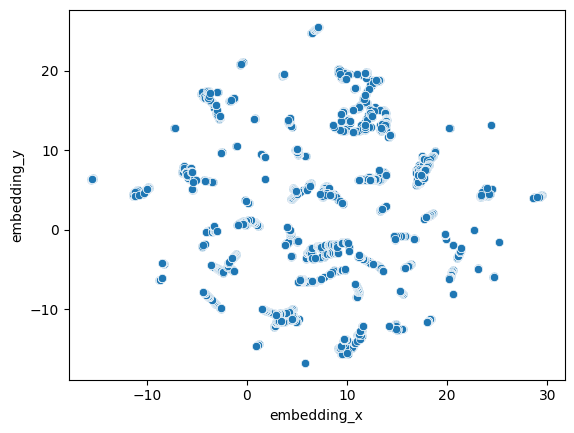

In [71]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data=df_tree)

## <font color='red'> 5.0. Data Preparation </font>

In [72]:
X = df_tree.copy()

In [73]:
X.head()

,embedding_x,embedding_y
0,11.888291,17.069336
1,9.237153,12.700115
2,11.641881,16.500788
3,-10.258701,4.815039
4,20.216818,12.748639


## <font color='red'> 6.0. Model Training </font>

### 6.1. Final Model

In [92]:
# model definition GMM
k = 23
gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state = 42 )

# model training
gmm_model.fit( X )

# model predict
labels = gmm_model.predict( X )

### 6.2. Cluster Validation

In [93]:
## SS ( Silhouette Score )
print ( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.522651195526123


## <font color='red'> 7.0. Cluster Analysis </font>

### 7.1. Cluster Profile

In [94]:
df92 = df4[ cols_selected ].copy()
df92['cluster'] = labels

# change dtypes
df92['recency_days'] = df92['recency_days'].astype( int )
df92['qtde_products'] = df92['qtde_products'].astype( int )
df92['qtde_returns'] = df92['qtde_returns'].astype( int )

In [95]:
# Number of Customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Average Gross Revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Average Recency Days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Average Invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster')

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster')

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster')

df_cluster.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,355,6.233538,11115.091239,65.676056,534.532394,0.367240,401.692958
14,14,602,10.570676,2827.912110,57.337209,188.918605,0.232220,20.061462
2,2,293,5.144864,2147.268430,108.081911,147.921502,0.574562,2.395904
16,16,249,4.372256,2114.770120,91.546185,40.502008,0.767023,11.389558
4,4,337,5.917471,2012.773086,90.652819,137.670623,0.400045,0.091988
20,20,230,4.038630,1762.084304,75.421739,90.169565,0.262184,8.678261
13,13,171,3.002634,1239.196257,123.736842,60.222222,0.258376,11.906433
22,22,40,0.702371,1238.771000,94.075000,33.725000,0.033032,48.575000
17,17,255,4.477612,1156.414667,60.733333,55.443137,0.026856,10.572549
8,8,187,3.283582,1082.974706,98.743316,50.641711,0.340437,4.930481


0   Cluster Insiders

14/2 Clusters Quase Insiders

2  Cluster Precisa de Mais Valor "Expend Money"

16   Cluster Mais valor / Frequencia





### Cluster Insiders: ( Cluster 0 )
    - Número de customers: 373 ( 12,5% dos customers )
    - Faturamento médio: 10500
    - Recência em média: 19 dias
    - Média de produtos comprados: 475 produtos
    - Frequência de produtos comprados: 0,11 produtos/dia

### Cluster 02:
    - Número de customers: 31 ( 71% dos customers )
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52

### Cluster 03:
    - Número de customers: 4335 ( 99% dos customers )
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57

## <font color='red'> 8.0 Deploy To Production </font>

In [82]:
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372,297,17.000000,40,0
1,13047,3232.59,56,171,0.028302,35,14
2,12583,6705.38,2,232,0.040323,50,14
3,13748,948.25,95,28,0.017921,0,21
4,15100,876.00,333,3,0.073171,22,22


In [83]:
df92.dtypes

customer_id        int64
gross_revenue    float64
recency_days       int64
qtde_products      int64
frequency        float64
qtde_returns       int64
cluster            int64
dtype: object

### 8.1 Inserto into SQLITE

In [84]:
import sqlite3
from sqlalchemy import create_engine

In [85]:
df92['recency_days'] = df92['recency_days'].astype( int )
df92['qtde_products'] = df92['qtde_products'].astype( int )
df92['qtde_returns'] = df92['qtde_returns'].astype( int )

#df92['last_training_timestamp'] = datetime.now().strftime( '%Y-%m-%d %H:%M%S' )

In [100]:
# database conection
conn = create_engine( 'sqlite:///insiders_db.sqlite')

# # drop table
# query_drop_insiders = """
#     DROP TABLE insiders
# """

# create table
query_create_insiders = """
    CREATE TABLE insiders (
        customer_id     INTEGER,
        gross_revenue   REAL,
        recency_days    INTEGER,
        qtde_products   INTEGER,
        frequency       REAL,
        qtde_returns    INTEGER,
        cluster         INTEGER
    )
"""    

# #conn = sqlite3.connect( 'insiders_db.sqlite')

conn.execute( query_create_insiders )

In [104]:
 # insert data
df92.to_sql( 'insiders', con=conn, if_exists='append', index=False )

5695

In [105]:
# # consulting database / get query
# query_collect = """
#     SELECT * FROM insiders
# """

# df = pd.read_sql_query( query_collect, conn )
# df.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372,297,17.000000,40,0
1,13047,3232.59,56,171,0.028302,35,14
2,12583,6705.38,2,232,0.040323,50,14
3,13748,948.25,95,28,0.017921,0,21
4,15100,876.00,333,3,0.073171,22,22
